데이터를 다룰 때는 `numpy`배열로 불러와 그 후 `torch.*tensor` 로 변환

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose(  #transform.Compose : 여러 transform 진행
    [transforms.ToTensor(), #transforms.ToTensor(): PIL 이미지 또는 numpy.ndarray를 pytorch의 tensor로 변형
                            #PIL 이미지나 numpy.ndarray 등은 이미지가 (HxWxC)형태와 0~255의 값
                            #tensor는 (CxHxW)순서와 0.0부터 1.0사이의 값
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                            #transforms.Normalize(): 평균과 표준편차를 사용하여 이미지를 정규화

#학습데이터 로드
#DataLoader는 iterator를 반환
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, #torchvision.datasets 중 CIFAR10 이용
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, #batch 이미지 : 4x32x32
                                          shuffle=True, num_workers=2) #train의 경우 shuffle=True를 통해 다양하게 학습 진행
                                                                       #num_workers는 batch size가 커질수록 높게 설정하는 것이 좋다.
                                                                       #이미지를 가지고 오는 것은 cpu가 처리하기 때문에
                                                                       #cpu 코어를 몇개 사용하는 가에 따라 연산 속도가 달라진다.
    
#평가데이터 로드
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


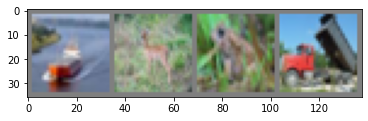

 ship  deer  frog truck


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
def imshow(img): #tensor를 다시 numpy로 변환하여 이미지를 시각화하는 함수
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # 앞서서 이미지를 h*w*c(높이*너비*채널) 순서의 tensor로 변환해주었기 때문에
    # 다시 시각화를 하기 위해서 c(0)*h(1)*w(2) 형태로 바꿔준다.
    plt.show()

# 랜덤으로 학습이미지를 얻는다
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


#### * cnn 정의하기
3채널 이미지처리

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


#### * loss func과 optimizer정의
교차 엔트로피 손실(cross-entropy loss)과 모멘텀(momentum)값을 갖는 SGD 사용

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#### * 신경망 학습하기

In [18]:
for epoch in range(5):   # 데이터셋을 수차례 반복

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.244
[1,  4000] loss: 1.246
[1,  6000] loss: 1.239
[1,  8000] loss: 1.228
[1, 10000] loss: 1.261
[1, 12000] loss: 1.249
[2,  2000] loss: 1.250
[2,  4000] loss: 1.241
[2,  6000] loss: 1.249
[2,  8000] loss: 1.259
[2, 10000] loss: 1.221
[2, 12000] loss: 1.239
[3,  2000] loss: 1.242
[3,  4000] loss: 1.251
[3,  6000] loss: 1.235
[3,  8000] loss: 1.240
[3, 10000] loss: 1.259
[3, 12000] loss: 1.229
[4,  2000] loss: 1.257
[4,  4000] loss: 1.254
[4,  6000] loss: 1.245
[4,  8000] loss: 1.250
[4, 10000] loss: 1.224
[4, 12000] loss: 1.228
[5,  2000] loss: 1.246
[5,  4000] loss: 1.237
[5,  6000] loss: 1.245
[5,  8000] loss: 1.231
[5, 10000] loss: 1.246
[5, 12000] loss: 1.254
Finished Training



#### * 학습한 모델 저장

In [25]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

#### * 시험용 데이터로 신경망 검사 및 이미지 출력

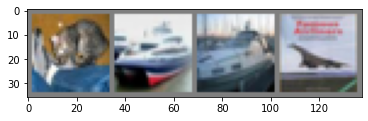

GroundTruth:    cat  ship  ship plane


In [26]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### * 저장한 모델 불러오기

In [27]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#### * 신경망이 어떻게 예측했는지 관찰

In [28]:
outputs = net(images)

In [29]:
#가장 높은 값을 갖는 인덱스를 뽑음

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car   car


#### * 전체 데이터셋에 대한 동작


In [30]:
correct = 0
total = 0
with torch.no_grad(): #test 이므로 변화도(gradient) 측정x
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


#### * 어떤 것들을 잘 분류했는지 관찰


In [14]:
#list 내포의 일반 문법 : [표현식 for 항목 in 반복가능 객체 if 조건문]
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad(): #변화도(gradient) 측정x
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 68 %
Accuracy of   car : 66 %
Accuracy of  bird : 37 %
Accuracy of   cat : 55 %
Accuracy of  deer : 56 %
Accuracy of   dog : 44 %
Accuracy of  frog : 48 %
Accuracy of horse : 43 %
Accuracy of  ship : 76 %
Accuracy of truck : 48 %
